# Setup

In [1]:
import random
import numpy as np
import keras
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

2024-02-23 14:40:27.566536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Hyperparameters

In [2]:
epochs = 10
batch_size = 16
margin = 1  # Margin for contrastive loss.

# Load the Olivetti dataset

In [3]:
data = fetch_olivetti_faces()
face_images = data.images
face_labels = data.target

x_train_val, x_test, y_train_val, y_test = train_test_split(
    face_images, face_labels, test_size=0.2, random_state=42
)

# Change the data type to a floating point format
x_train_val = x_train_val.astype("float32")
x_test = x_test.astype("float32")

# Define training and validation sets

In [4]:
len(x_train_val)

320

In [5]:
# Keep 50% of train_val  in validation set
x_train, x_val = x_train_val[:160], x_train_val[160:]
y_train, y_val = y_train_val[:160], y_train_val[160:]
del x_train_val, y_train_val

# Create pairs of images

In [7]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1 or len(digit_indices[label2]) == 0:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [8]:

def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

        label2 = random.randint(0, num_classes - 1)
        while label2 == label1 or len(digit_indices[label2]) == 0:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [9]:
x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (320, 64, 64)
x_train_2 = pairs_train[:, 1]

In [10]:
x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (320, 64, 64)
x_val_2 = pairs_val[:, 1]

In [11]:
x_test_1 = pairs_test[:, 0]  # x_test_1.shape = (160, 64, 64)
x_test_2 = pairs_test[:, 1]

# Visualize pairs and their labels


In [12]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

            ax.imshow(np.concatenate([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

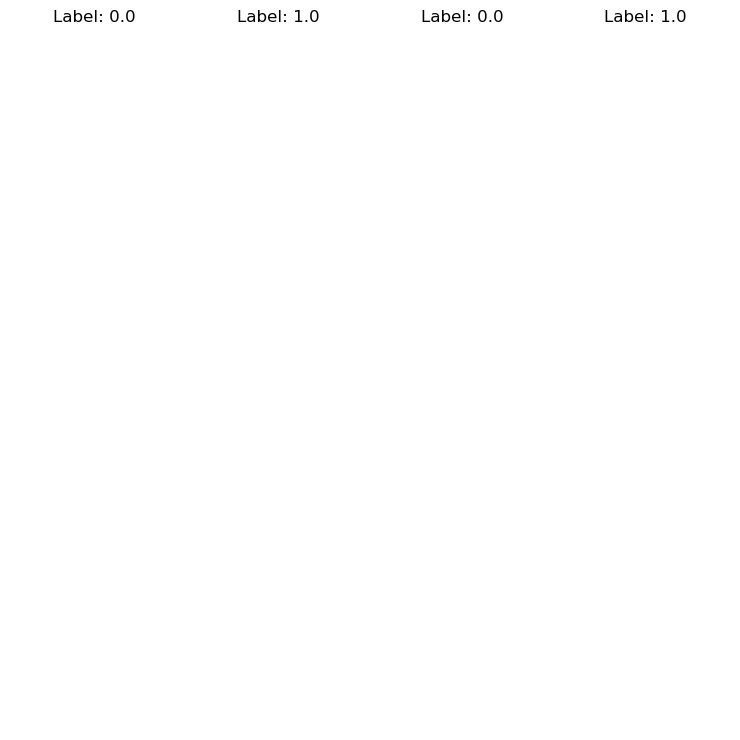

In [15]:
visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

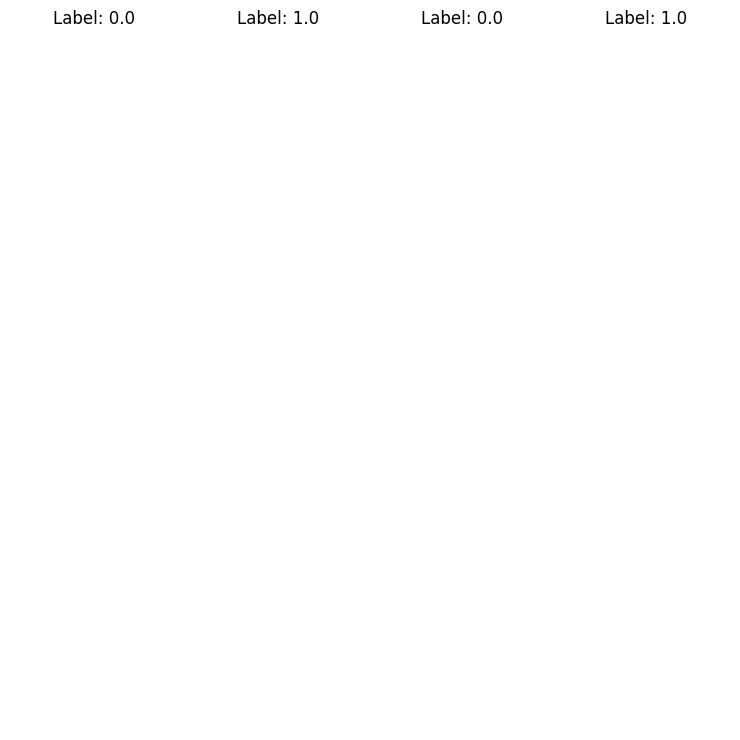

In [64]:
visualize(pairs_val[:-1], labels_val[:-1], to_show=4, num_col=4)

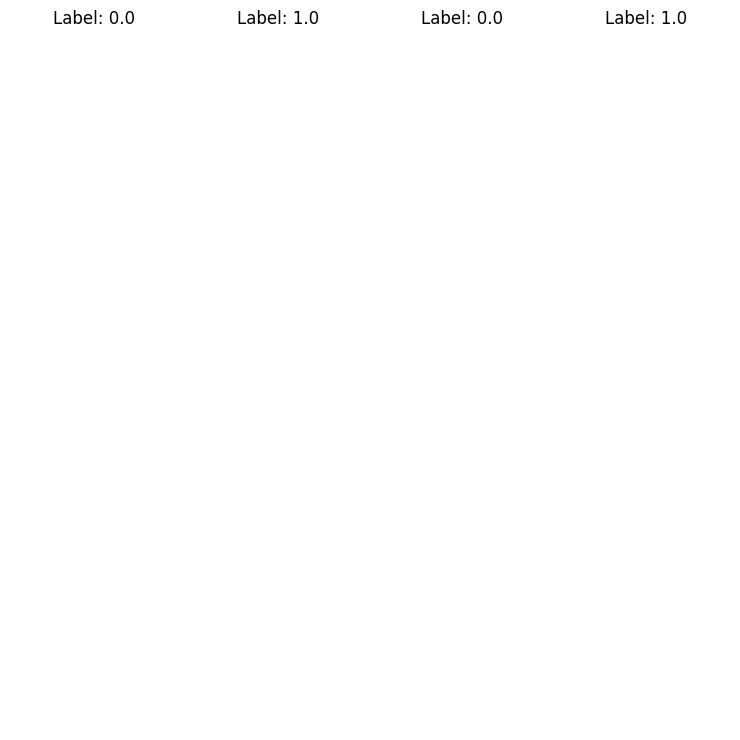

In [65]:
visualize(pairs_test[:-1], labels_test[:-1], to_show=4, num_col=4)

# Define Model

In [79]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


input = keras.layers.Input((64, 64, 1))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(4, (5, 5), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(16, (5, 5), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="relu")(x)
embedding_network = keras.Model(input, x)


input_1 = keras.layers.Input((64, 64, 1))
input_2 = keras.layers.Input((64, 64, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

# Define Contrastive Loss

In [80]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - (y_pred), 0))
        return K.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

# Compile the model with the contrastive loss


In [81]:
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 model_4 (Functional)        (None, 10)                   39590     ['input_8[0][0]',             
                                                                     'input_9[0][0]']             
                                                                                                  
 lambda_2 (Lambda)           (None, 1)                    0         ['model_4[0][0]',       

In [82]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=150,
)

Epoch 1/150
20/20 [==============================] - 4s 134ms/step - loss: 0.1713 - accuracy: 0.7656 - val_loss: 0.2513 - val_accuracy: 0.5000
Epoch 2/150
20/20 [==============================] - 3s 166ms/step - loss: 0.1189 - accuracy: 0.8906 - val_loss: 0.2656 - val_accuracy: 0.5000
Epoch 3/150
20/20 [==============================] - 3s 125ms/step - loss: 0.1070 - accuracy: 0.9187 - val_loss: 0.2838 - val_accuracy: 0.5000
Epoch 4/150
20/20 [==============================] - 2s 122ms/step - loss: 0.0925 - accuracy: 0.9688 - val_loss: 0.2866 - val_accuracy: 0.5000
Epoch 5/150
20/20 [==============================] - 2s 120ms/step - loss: 0.0856 - accuracy: 0.9812 - val_loss: 0.2890 - val_accuracy: 0.5000
Epoch 6/150
20/20 [==============================] - 2s 122ms/step - loss: 0.0768 - accuracy: 0.9875 - val_loss: 0.2753 - val_accuracy: 0.5000
Epoch 7/150
20/20 [==============================] - 4s 189ms/step - loss: 0.0705 - accuracy: 0.9906 - val_loss: 0.2846 - val_accuracy: 0.5000

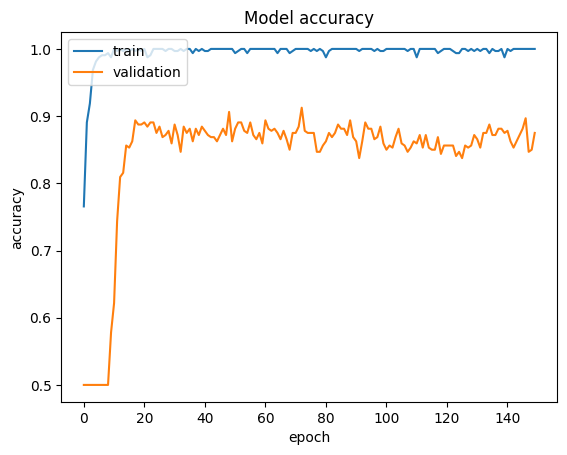

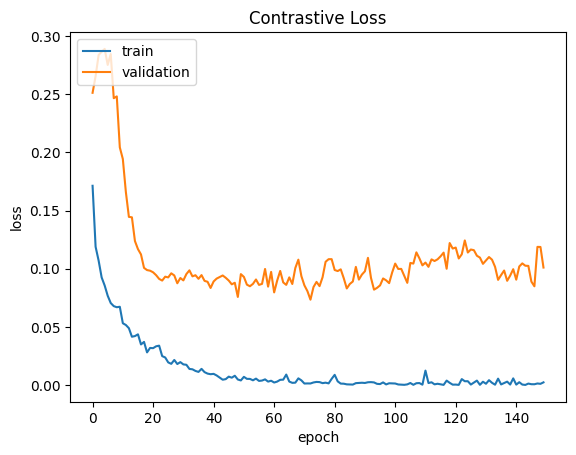

In [83]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")
# plt.savefig('./images/model_accuray_loss')

In [84]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

5/5 [==============================] - 1s 71ms/step - loss: 0.0666 - accuracy: 0.9187
test loss, test acc: [0.06661296635866165, 0.918749988079071]


5/5 [==============================] - 0s 42ms/step


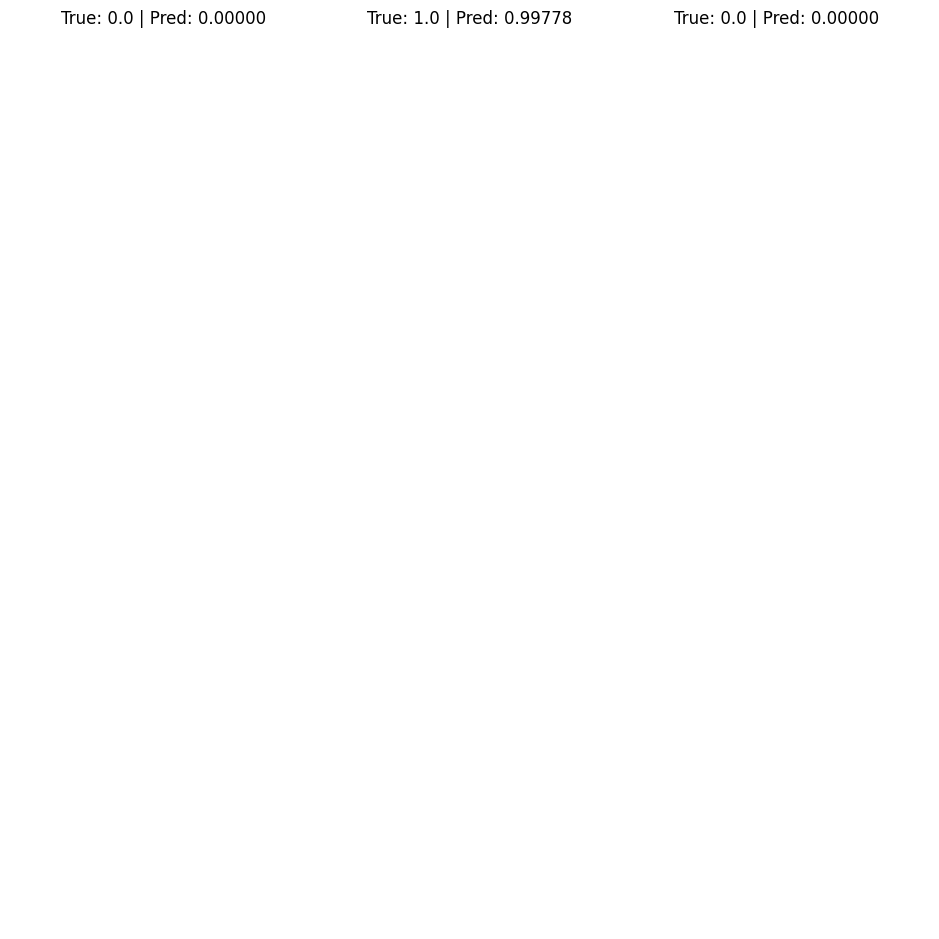

In [85]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)

In [92]:
import os
os.listdir('../..')

['lib',
 'sys',
 'var',
 'etc',
 'tmp',
 'lib32',
 'media',
 'sbin',
 'opt',
 'boot',
 'bin',
 'libx32',
 'run',
 'lib64',
 'srv',
 'usr',
 'home',
 'mnt',
 'proc',
 'root',
 'dev',
 '.dockerenv',
 'tools',
 'datalab',
 'content',
 'NGC-DL-CONTAINER-LICENSE',
 'cuda-keyring_1.0-1_all.deb']

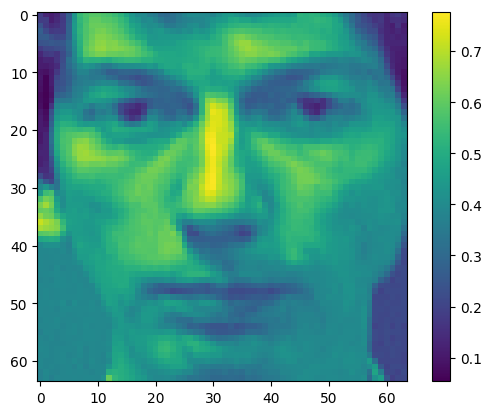

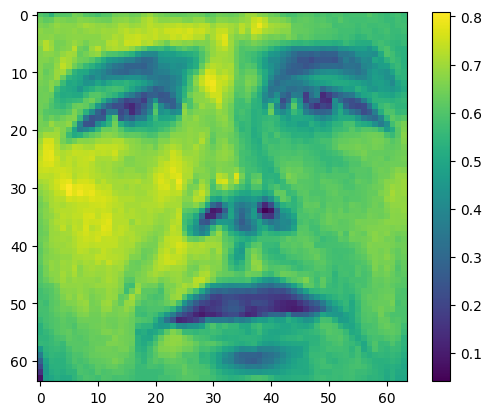

1.0


In [88]:
pairs_test[0]
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

this_pair = 3
show_image(pairs_test[this_pair][0])
show_image(pairs_test[this_pair][1])
print(labels_test[this_pair])